# Main notebook for battery state estimation

In [1]:
import numpy as np
import pandas as pd
import scipy.io
import math
import os
import ntpath
import sys
import logging
import time
import sys

from importlib import reload
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import tikzplotlib
from matplotlib.font_manager import FontProperties

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
from keras.layers import LSTM, Embedding, RepeatVector, TimeDistributed, Masking
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback


IS_COLAB = False

if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    data_path = "/content/drive/My Drive/battery-state-estimation/battery-state-estimation/"
else:
    data_path = "../../"

sys.path.append(data_path)
from data_processing.lg_dataset import LgData

### Config logging

In [2]:
reload(logging)
logging.basicConfig(format='%(asctime)s [%(levelname)s]: %(message)s', level=logging.DEBUG, datefmt='%Y/%m/%d %H:%M:%S')

# Load Data

In [3]:
train_names = [
    '0degC/589_Mixed1',
    '0degC/589_Mixed2',
    '0degC/590_Mixed4',
    '0degC/590_Mixed5',
    '0degC/590_Mixed6',
    '0degC/590_Mixed8',

    '10degC/567_Mixed1',
    '10degC/567_Mixed2',
    '10degC/571_Mixed4',
    '10degC/571_Mixed5',
    '10degC/571_Mixed6',
    '10degC/571_Mixed8',
    
    '25degC/551_Mixed1', 
    '25degC/551_Mixed2', 
    #'25degC/552_Mixed3',
    '25degC/552_Mixed4', 
    '25degC/552_Mixed5', 
    '25degC/552_Mixed6', 
    '25degC/552_Mixed8',   
    ]
test_names = [
    '0degC/589_LA92',
    '0degC/589_UDDS',
    '0degC/589_US06',
    #'0degC/589_HWFET',
    '0degC/590_Mixed7',    
        
    '10degC/582_LA92',
    '10degC/576_UDDS',
    '10degC/567_US06',
    #'10degC/576_HWFET',
    '10degC/571_Mixed7',

    '25degC/551_LA92', 
    '25degC/551_UDDS', 
    '25degC/551_US06',
    #'25degC/551_HWFET',
    '25degC/552_Mixed7', 
    ]

steps = 300

lg_data = LgData(data_path)
cycles = lg_data.get_discharge_whole_cycle(train_names, test_names, output_capacity=False, scale_test=True, output_time=True)
train_x, train_y, test_x, test_y = lg_data.get_discharge_multiple_step(cycles, steps)

train_y = lg_data.keep_only_y_end(train_y, steps)
test_y = lg_data.keep_only_y_end(test_y, steps)

2021/01/14 18:37:07 [INFO]: There is a NaN in cycle 10degC/582_LA92, removing row
2021/01/14 18:37:36 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (3218, 300, 3), test y: (3218, 300, 2)


In [4]:
# Model definition

#opt = tf.keras.optimizers.Adam(lr=0.00001)

#model = Sequential()
#model.add(LSTM(256, activation='selu',
#                return_sequences=True,
#                input_shape=(train_x.shape[1], train_x.shape[2])))
#model.add(LSTM(256, activation='selu', return_sequences=False))
#model.add(Dense(256, activation='selu'))
#model.add(Dense(128, activation='selu'))
#model.add(Dense(1, activation='linear'))
#model.summary()

#model.compile(optimizer=opt, loss='huber', metrics=['mse', 'mae', 'mape', tf.keras.metrics.RootMeanSquaredError(name='rmse')

In [5]:
experiment_name = '2021-01-12-23-17-13_lstm_soc_percentage_lg_positive_temp_300_steps_mixed_cycle_test'

history = pd.read_csv(data_path + 'results/trained_model/%s_history.csv' % experiment_name)
model = keras.models.load_model(data_path + 'results/trained_model/%s.h5' % experiment_name)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300, 256)          266240    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 890,369
Trainable params: 890,369
Non-trainable params: 0
_________________________________________________________________


In [6]:
print(history)

     Unnamed: 0      loss       mse       mae       mape      rmse  val_loss  \
0             0  0.010751  0.021504  0.092660  57.806381  0.146642  0.001062   
1             1  0.001235  0.002471  0.037531  22.637829  0.049708  0.000748   
2             2  0.000970  0.001940  0.033608  19.300547  0.044045  0.000788   
3             3  0.000901  0.001802  0.032795  19.490223  0.042448  0.000536   
4             4  0.000786  0.001571  0.030548  18.266016  0.039642  0.000496   
..          ...       ...       ...       ...        ...       ...       ...   
292         292  0.000127  0.000255  0.012314   5.865608  0.015963  0.000198   
293         293  0.000134  0.000267  0.012503   5.727811  0.016354  0.000082   
294         294  0.000165  0.000330  0.013974   6.323273  0.018152  0.000566   
295         295  0.000176  0.000352  0.014641   6.739522  0.018764  0.000191   
296         296  0.000121  0.000242  0.011934   5.587369  0.015559  0.000114   

      val_mse   val_mae   val_mape  val

# Test

In [7]:
results = model.evaluate(test_x, test_y[:,:,0])
print(results)

101/101 [==============================] - 9s 88ms/step - loss: 1.9788e-04 - mean_squared_error: 3.9577e-04 - mean_absolute_error: 0.0147 - mean_absolute_percentage_error: 8.7311 - rmse: 0.0199
[0.00019788475765381008, 0.00039576951530762017, 0.014733720570802689, 8.731064796447754, 0.019893957301974297]


# Data Visualization

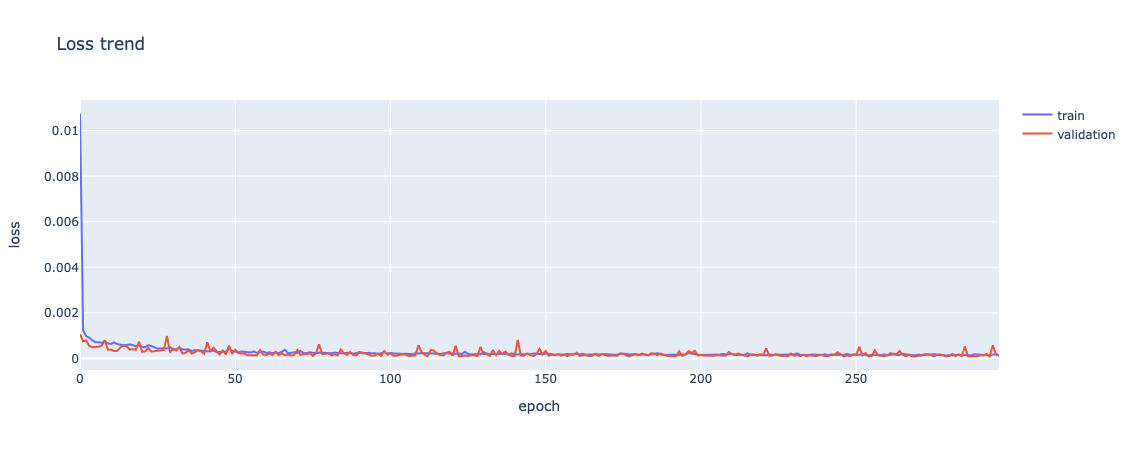

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history['loss'],
                    mode='lines', name='train'))
fig.add_trace(go.Scatter(y=history['val_loss'],
                    mode='lines', name='validation'))
fig.update_layout(title='Loss trend',
                  xaxis_title='epoch',
                  yaxis_title='loss')
fig.show()

In [9]:
train_predictions = model.predict(train_x)

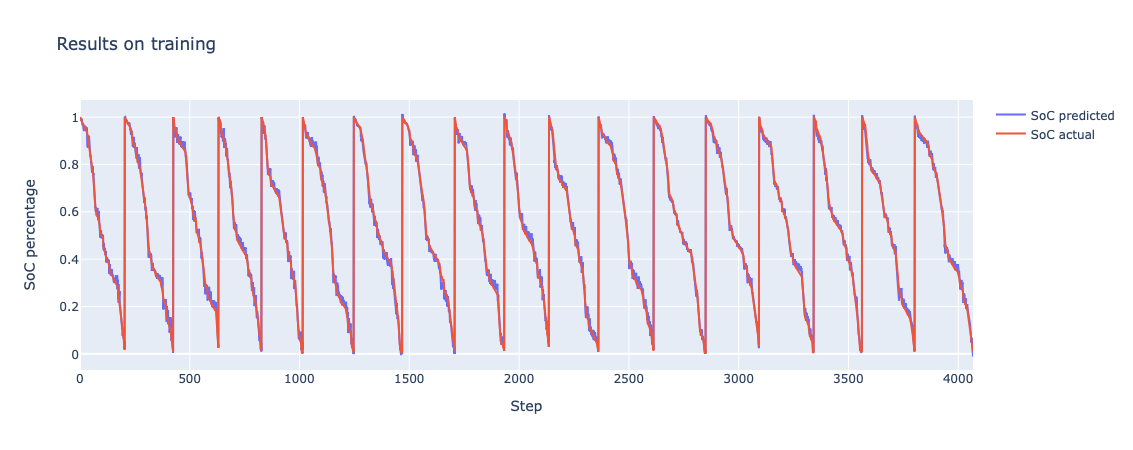

In [10]:
cycle_num = 0
steps_num = 8000
step_index = np.arange(cycle_num*steps_num, (cycle_num+1)*steps_num)

fig = go.Figure()
fig.add_trace(go.Scatter(x=step_index, y=train_predictions.flatten()[cycle_num*steps_num:(cycle_num+1)*steps_num],
                    mode='lines', name='SoC predicted'))
fig.add_trace(go.Scatter(x=step_index, y=train_y[:,:,0].flatten()[cycle_num*steps_num:(cycle_num+1)*steps_num],
                    mode='lines', name='SoC actual'))
fig.update_layout(title='Results on training',
                  xaxis_title='Step',
                  yaxis_title='SoC percentage')
fig.show()

# Testing

Test model performance on every temperature dataset

In [14]:
font = FontProperties()
font.set_family('serif')
font.set_name('Linux Libertine')

In [19]:
def get_test_data(test_names):
    lg_data = LgData(data_path)
    cycles = lg_data.get_discharge_whole_cycle(train_names, test_names, output_capacity=False, scale_test=True, output_time=True)
    _, _, test_x, test_y = lg_data.get_discharge_multiple_step(cycles, steps)
    test_y = lg_data.keep_only_y_end(test_y, steps)    
    return test_x, test_y

def plot_test_performance(test_x, test_y):
    test_predictions = model.predict(test_x)
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=test_y[:,:,1].flatten(), y=test_predictions.flatten(),
                        mode='lines', name='SoC predicted'))
    fig.add_trace(go.Scatter(x=test_y[:,:,1].flatten(), y=test_y[:,:,0].flatten(),
                        mode='lines', name='SoC actual'))
    fig.update_layout(title='Results on testing',
                      xaxis_title='Time(s)',
                      yaxis_title='SoC percentage')
    fig.show()
    
def gen_chart(test_name, test_x, test_y):
    test_predictions = model.predict(test_x)
    
    f = plt.figure(figsize=(5,2))
    plt.plot(test_y[:,:,1].flatten(), test_y[:,:,0].flatten(), label='Actual', color='black')
    plt.plot(test_y[:,:,1].flatten(), test_predictions.flatten(), label='Estimated', linestyle='--', color='red')
    plt.xlabel('Time(s)', fontproperties=font)
    plt.ylabel('SOC', fontproperties=font)
    plt.legend()
    plt.show()
    f.savefig('./lstm_soc_percentage_lg_positive_temp_300_steps_mixed_cycle_test_%s.pdf' % test_name, bbox_inches='tight')
    
def show_result(cycle, name):
    test_x, test_y = get_test_data([cycle])

    print(model.evaluate(test_x, test_y[:,:,0]))
    plot_test_performance(test_x, test_y)

    test_x, test_y = get_test_data([cycle])
    gen_chart(name, test_x, test_y)

## 0C

2021/01/14 18:44:57 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (976, 300, 3), test y: (976, 300, 2)


31/31 [==============================] - 3s 87ms/step - loss: 2.5701e-04 - mean_squared_error: 5.1402e-04 - mean_absolute_error: 0.0169 - mean_absolute_percentage_error: 13.0176 - rmse: 0.0227
[0.0002570112410467118, 0.0005140224820934236, 0.01689271256327629, 13.017587661743164, 0.02267206460237503]


2021/01/14 18:45:21 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (251, 300, 3), test y: (251, 300, 2)


8/8 [==============================] - 1s 80ms/step - loss: 1.3673e-04 - mean_squared_error: 2.7346e-04 - mean_absolute_error: 0.0125 - mean_absolute_percentage_error: 7.0246 - rmse: 0.0165
[0.00013672975182998925, 0.0002734595036599785, 0.012536490336060524, 7.0245513916015625, 0.016536610201001167]


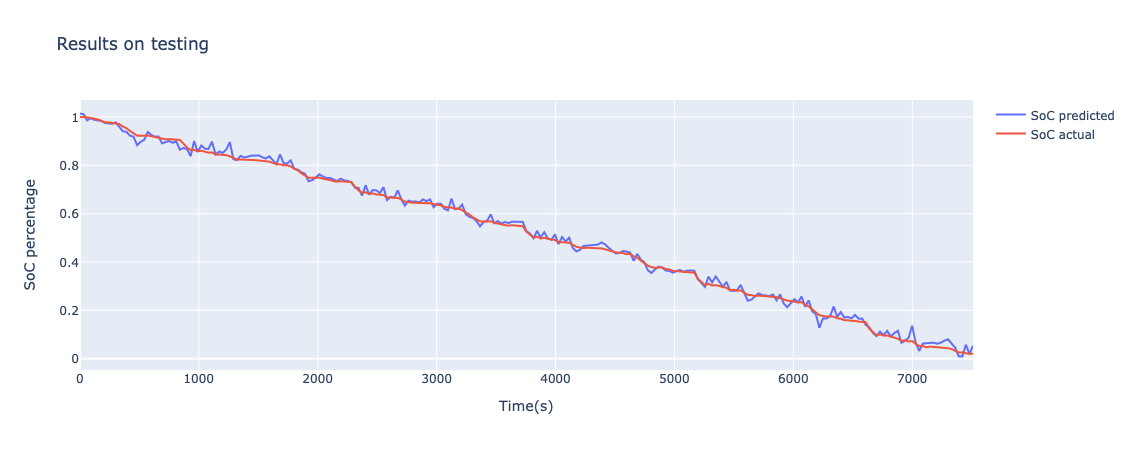

2021/01/14 18:45:42 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (251, 300, 3), test y: (251, 300, 2)


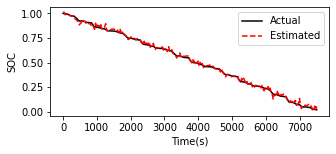

2021/01/14 18:45:43 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/14 18:45:43 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/14 18:45:43 [DEBUG]: Writing TrueType font.
2021/01/14 18:46:04 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (448, 300, 3), test y: (448, 300, 2)


14/14 [==============================] - 1s 84ms/step - loss: 2.1504e-04 - mean_squared_error: 4.3009e-04 - mean_absolute_error: 0.0166 - mean_absolute_percentage_error: 18.7413 - rmse: 0.0207
[0.00021504273172467947, 0.00043008546344935894, 0.016571534797549248, 18.741254806518555, 0.020738501101732254]


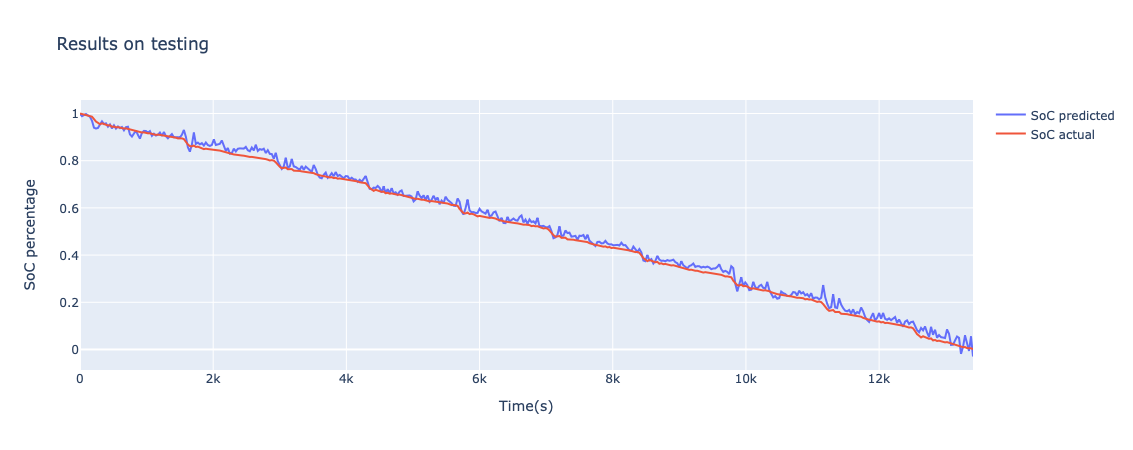

2021/01/14 18:46:27 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (448, 300, 3), test y: (448, 300, 2)


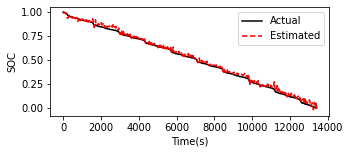

2021/01/14 18:46:29 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/14 18:46:29 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/14 18:46:29 [DEBUG]: Writing TrueType font.
2021/01/14 18:46:49 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (92, 300, 3), test y: (92, 300, 2)


3/3 [==============================] - 0s 64ms/step - loss: 6.0865e-04 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 9.6733 - rmse: 0.0349
[0.0006086454959586263, 0.0012172909919172525, 0.025683190673589706, 9.673285484313965, 0.03488969802856445]


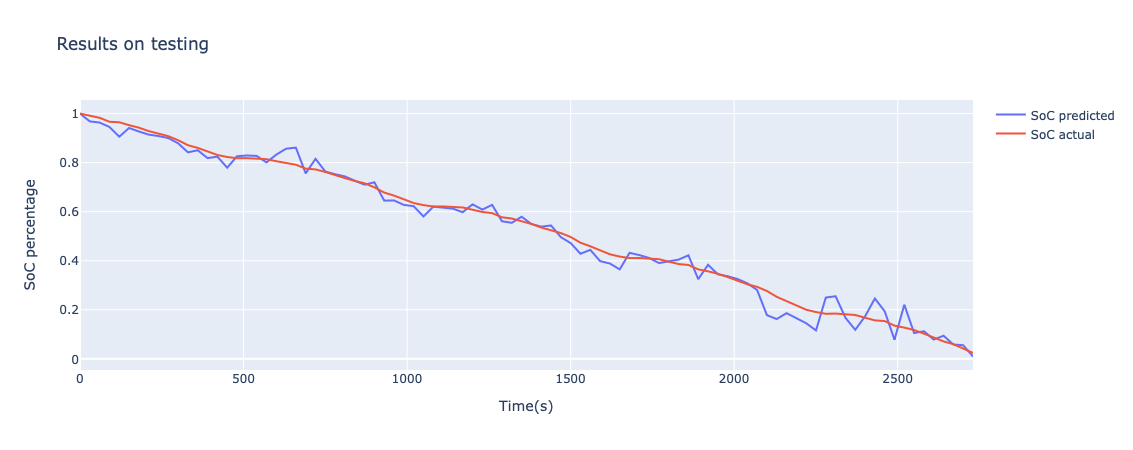

2021/01/14 18:47:09 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (92, 300, 3), test y: (92, 300, 2)


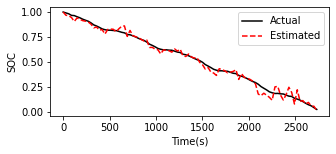

2021/01/14 18:47:10 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/14 18:47:10 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/14 18:47:10 [DEBUG]: Writing TrueType font.
2021/01/14 18:47:30 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (185, 300, 3), test y: (185, 300, 2)


6/6 [==============================] - 0s 74ms/step - loss: 3.4697e-04 - mean_squared_error: 6.9394e-04 - mean_absolute_error: 0.0192 - mean_absolute_percentage_error: 8.9512 - rmse: 0.0263
[0.00034696879447437823, 0.0006939375889487565, 0.019209323450922966, 8.951239585876465, 0.026342695578932762]


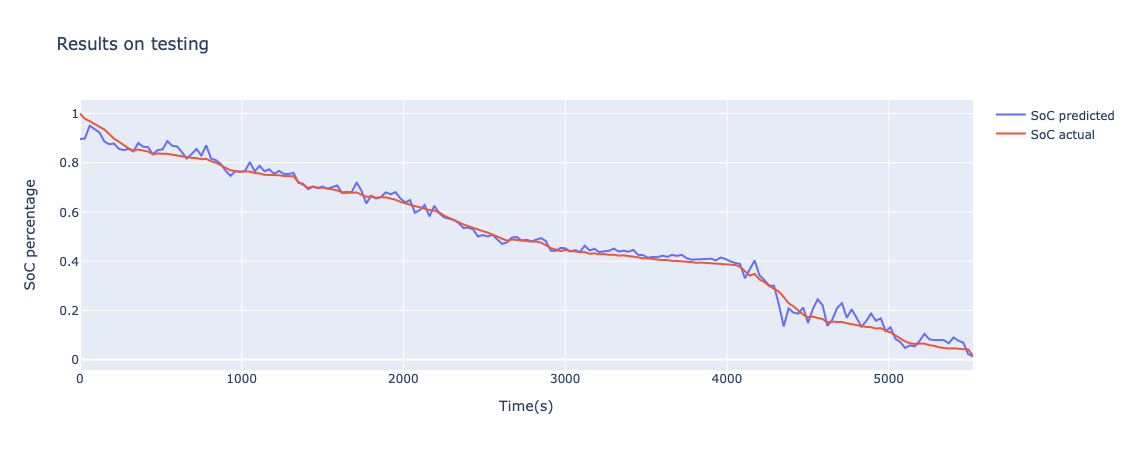

2021/01/14 18:47:52 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (185, 300, 3), test y: (185, 300, 2)


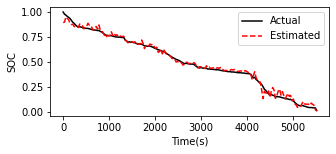

2021/01/14 18:47:52 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/14 18:47:52 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/14 18:47:52 [DEBUG]: Writing TrueType font.


In [20]:
test_x, test_y = get_test_data(['0degC/589_LA92', 
                                '0degC/589_UDDS', 
                                '0degC/589_US06', 
                                #'0degC/589_HWFET', 
                                '0degC/590_Mixed7'])
print(model.evaluate(test_x, test_y[:,:,0]))

show_result('0degC/589_LA92', '0degC_589_LA92')
show_result('0degC/589_UDDS', '0degC_589_UDDS')
show_result('0degC/589_US06', '0degC_589_US06')
#show_result('0degC/589_HWFET', '0degC_589_HWFET')
show_result('0degC/590_Mixed7', '0degC_590_Mixed7')

## 10C

2021/01/14 18:48:00 [INFO]: There is a NaN in cycle 10degC/582_LA92, removing row
2021/01/14 18:48:15 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (1078, 300, 3), test y: (1078, 300, 2)


34/34 [==============================] - 3s 85ms/step - loss: 2.2577e-04 - mean_squared_error: 4.5153e-04 - mean_absolute_error: 0.0161 - mean_absolute_percentage_error: 8.6160 - rmse: 0.0212
[0.00022576560149900615, 0.0004515312029980123, 0.01609964296221733, 8.615970611572266, 0.02124926447868347]


2021/01/14 18:48:38 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (476, 300, 3), test y: (476, 300, 2)


15/15 [==============================] - 1s 84ms/step - loss: 1.4189e-04 - mean_squared_error: 2.8378e-04 - mean_absolute_error: 0.0132 - mean_absolute_percentage_error: 8.4400 - rmse: 0.0168
[0.00014189239300321788, 0.00028378478600643575, 0.013175217434763908, 8.439971923828125, 0.016845913603901863]


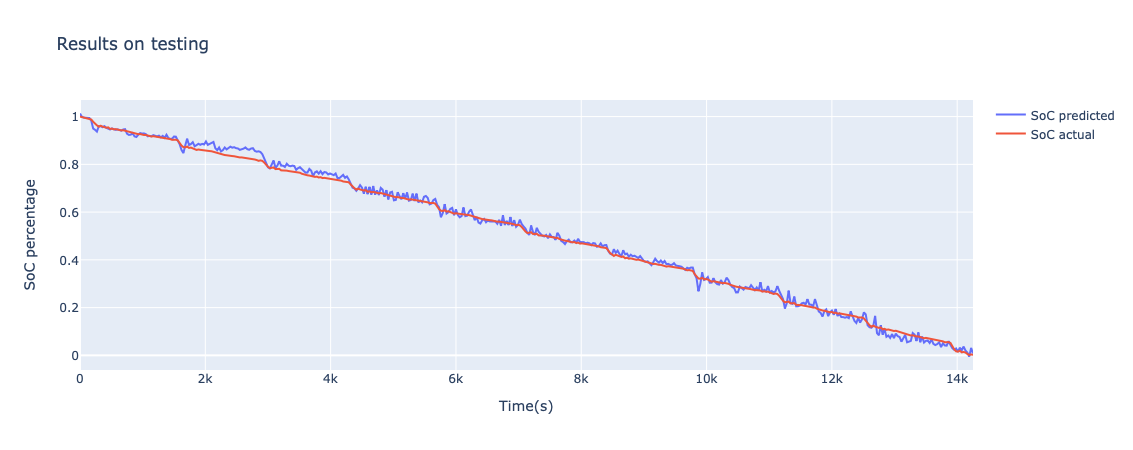

2021/01/14 18:49:02 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (476, 300, 3), test y: (476, 300, 2)


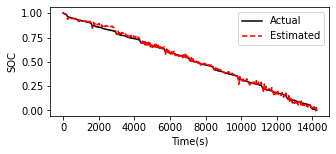

2021/01/14 18:49:04 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/14 18:49:04 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/14 18:49:04 [DEBUG]: Writing TrueType font.
2021/01/14 18:49:24 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (109, 300, 3), test y: (109, 300, 2)


4/4 [==============================] - 0s 65ms/step - loss: 7.1325e-04 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0312 - mean_absolute_percentage_error: 11.0588 - rmse: 0.0378
[0.0007132496102713048, 0.0014264992205426097, 0.031201446428894997, 11.05876636505127, 0.037769023329019547]


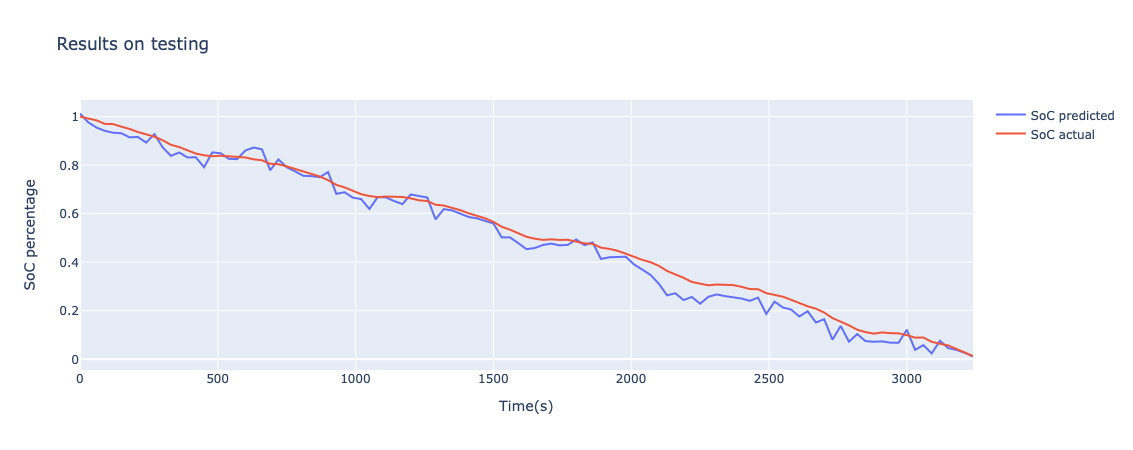

2021/01/14 18:49:45 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (109, 300, 3), test y: (109, 300, 2)


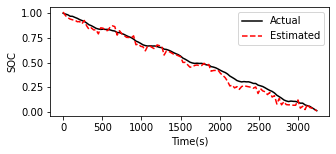

2021/01/14 18:49:46 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/14 18:49:46 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/14 18:49:46 [DEBUG]: Writing TrueType font.
2021/01/14 18:49:53 [INFO]: There is a NaN in cycle 10degC/582_LA92, removing row
2021/01/14 18:50:06 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (282, 300, 3), test y: (282, 300, 2)


9/9 [==============================] - 1s 81ms/step - loss: 1.6602e-04 - mean_squared_error: 3.3204e-04 - mean_absolute_error: 0.0146 - mean_absolute_percentage_error: 7.5741 - rmse: 0.0182
[0.00016601852257736027, 0.00033203704515472054, 0.01464369148015976, 7.574100017547607, 0.018221883103251457]


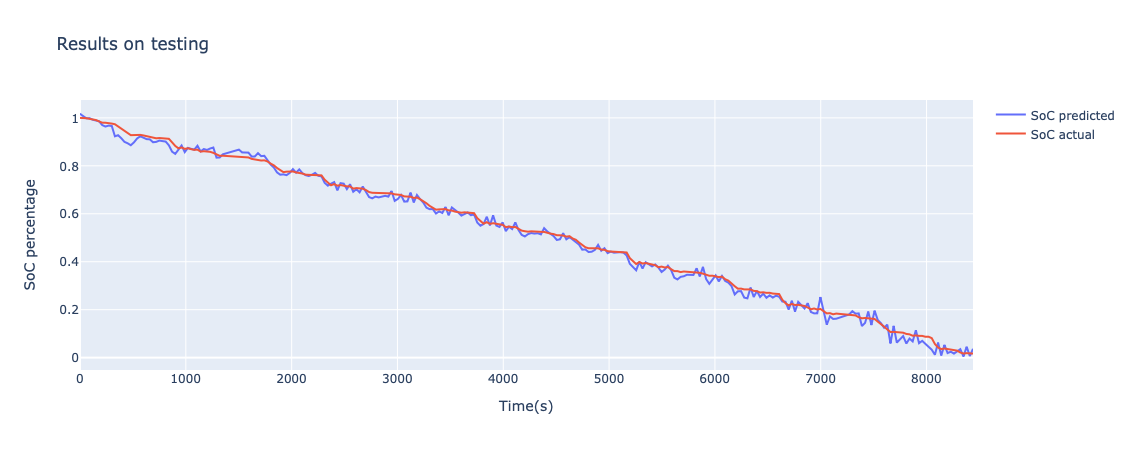

2021/01/14 18:50:15 [INFO]: There is a NaN in cycle 10degC/582_LA92, removing row
2021/01/14 18:50:28 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (282, 300, 3), test y: (282, 300, 2)


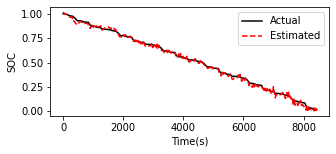

2021/01/14 18:50:29 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/14 18:50:29 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/14 18:50:29 [DEBUG]: Writing TrueType font.
2021/01/14 18:50:50 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (211, 300, 3), test y: (211, 300, 2)


7/7 [==============================] - 1s 77ms/step - loss: 2.4300e-04 - mean_squared_error: 4.8600e-04 - mean_absolute_error: 0.0168 - mean_absolute_percentage_error: 9.1435 - rmse: 0.0220
[0.0002430007152725011, 0.0004860014305450022, 0.01684139296412468, 9.143545150756836, 0.02204544097185135]


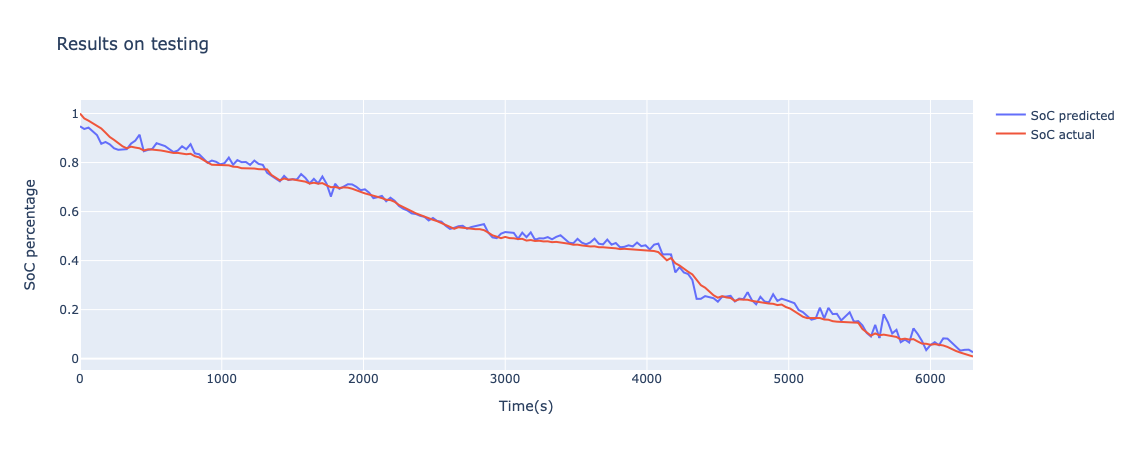

2021/01/14 18:51:11 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (211, 300, 3), test y: (211, 300, 2)


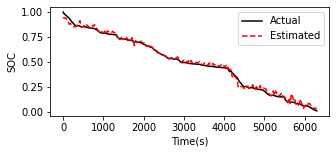

2021/01/14 18:51:12 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/14 18:51:12 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/14 18:51:12 [DEBUG]: Writing TrueType font.


In [21]:
test_x, test_y = get_test_data(['10degC/576_UDDS', 
                                '10degC/567_US06', 
                                '10degC/582_LA92',
                                #'10degC/576_HWFET', 
                                '10degC/571_Mixed7'])
print(model.evaluate(test_x, test_y[:,:,0]))

show_result('10degC/576_UDDS', '10degC_576_UDDS')
show_result('10degC/567_US06', '10degC_567_US06')
show_result('10degC/582_LA92', '10degC_582_LA92')
#show_result('10degC/576_HWFET', '10degC_576_HWFET')
show_result('10degC/571_Mixed7', '10degC_571_Mixed7')

## 25C

2021/01/14 18:51:35 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (1164, 300, 3), test y: (1164, 300, 2)


37/37 [==============================] - 3s 89ms/step - loss: 1.2249e-04 - mean_squared_error: 2.4497e-04 - mean_absolute_error: 0.0117 - mean_absolute_percentage_error: 5.2435 - rmse: 0.0157
[0.0001224869629368186, 0.0002449739258736372, 0.011658433824777603, 5.243462562561035, 0.0156516432762146]


2021/01/14 18:51:59 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (315, 300, 3), test y: (315, 300, 2)


10/10 [==============================] - 1s 79ms/step - loss: 9.3670e-05 - mean_squared_error: 1.8734e-04 - mean_absolute_error: 0.0103 - mean_absolute_percentage_error: 7.0284 - rmse: 0.0137
[9.366975427838042e-05, 0.00018733950855676085, 0.010286680422723293, 7.028393268585205, 0.013687202706933022]


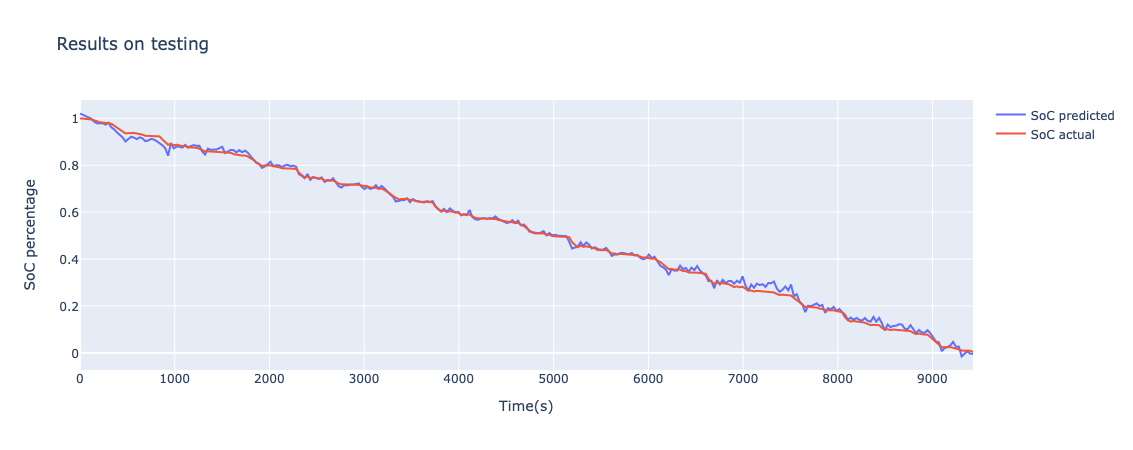

2021/01/14 18:52:21 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (315, 300, 3), test y: (315, 300, 2)


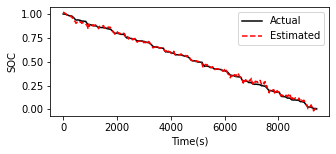

2021/01/14 18:52:22 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/14 18:52:22 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/14 18:52:22 [DEBUG]: Writing TrueType font.
2021/01/14 18:52:43 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (512, 300, 3), test y: (512, 300, 2)


16/16 [==============================] - 1s 87ms/step - loss: 7.8702e-05 - mean_squared_error: 1.5740e-04 - mean_absolute_error: 0.0096 - mean_absolute_percentage_error: 3.4915 - rmse: 0.0125
[7.870195258874446e-05, 0.00015740390517748892, 0.009610948152840137, 3.4914956092834473, 0.012546070851385593]


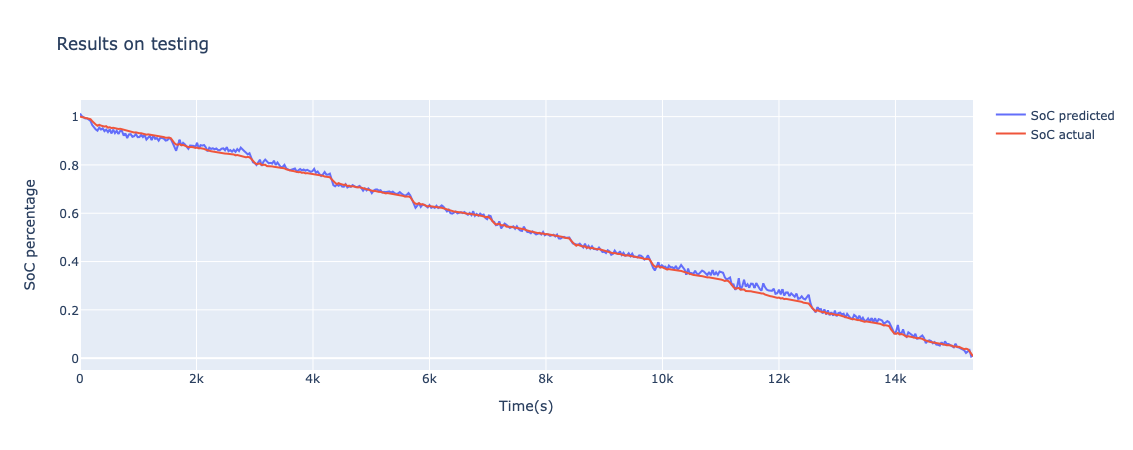

2021/01/14 18:53:07 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (512, 300, 3), test y: (512, 300, 2)


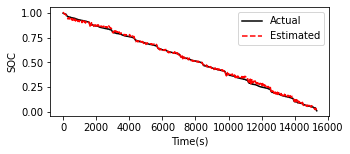

2021/01/14 18:53:09 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/14 18:53:09 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/14 18:53:09 [DEBUG]: Writing TrueType font.
2021/01/14 18:53:29 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (113, 300, 3), test y: (113, 300, 2)


4/4 [==============================] - 0s 69ms/step - loss: 3.5849e-04 - mean_squared_error: 7.1697e-04 - mean_absolute_error: 0.0226 - mean_absolute_percentage_error: 7.0734 - rmse: 0.0268
[0.0003584859659895301, 0.0007169719319790602, 0.022578714415431023, 7.07338285446167, 0.026776332408189774]


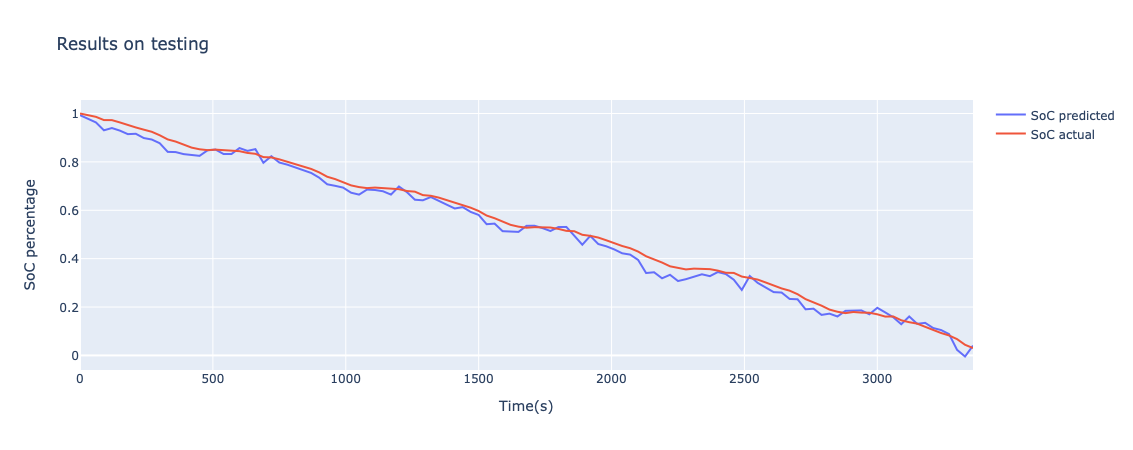

2021/01/14 18:53:50 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (113, 300, 3), test y: (113, 300, 2)


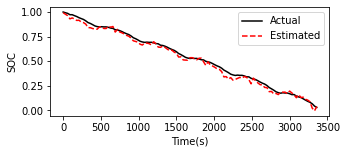

2021/01/14 18:53:51 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/14 18:53:51 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/14 18:53:51 [DEBUG]: Writing TrueType font.
2021/01/14 18:54:11 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (224, 300, 3), test y: (224, 300, 2)


7/7 [==============================] - 1s 80ms/step - loss: 1.4404e-04 - mean_squared_error: 2.8808e-04 - mean_absolute_error: 0.0128 - mean_absolute_percentage_error: 5.8148 - rmse: 0.0170
[0.00014403800014406443, 0.00028807600028812885, 0.012758532539010048, 5.814762115478516, 0.016972802579402924]


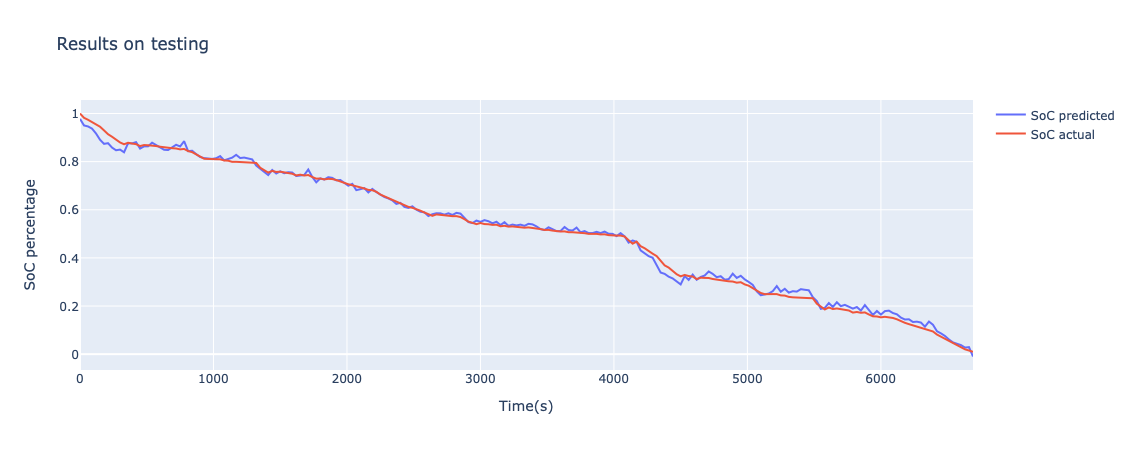

2021/01/14 18:54:33 [INFO]: Train x: (4068, 300, 3), train y: (4068, 300, 2) | Test x: (224, 300, 3), test y: (224, 300, 2)


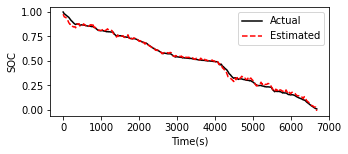

2021/01/14 18:54:34 [DEBUG]: Assigning font /b'F1' = '/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021/01/14 18:54:34 [DEBUG]: Embedding font /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021/01/14 18:54:34 [DEBUG]: Writing TrueType font.


In [22]:
test_x, test_y = get_test_data(['25degC/551_LA92', 
                                '25degC/551_UDDS', 
                                '25degC/551_US06', 
                                #'25degC/551_HWFET',
                                '25degC/552_Mixed7'])
print(model.evaluate(test_x, test_y[:,:,0]))

show_result('25degC/551_LA92', '25degC_551_LA92')
show_result('25degC/551_UDDS', '25degC_551_UDDS')
show_result('25degC/551_US06', '25degC_551_US06')
#show_result('25degC/551_HWFET', '25degC_551_HWFET')
show_result('25degC/552_Mixed7', '25degC_552_Mixed7')